In [ ]:
pip install gym numpy pandas torch stable-baselines3b

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!pip install shimmy>=2.0

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

import gym
from gym import spaces
import numpy as np

from stable_baselines3 import DDPG
from stable_baselines3.common.vec_env import DummyVecEnv

import matplotlib.pyplot as plt

In [ ]:
stocks = ['AAPL', 'MSFT', 'TSLA', 'NVDA', 'JPM']
stocks_raw_data = yf.download(stocks, start='2020-01-01', end='2024-12-31')['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


In [ ]:
data = stocks_raw_data.ffill().dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
train_size = int(0.8 * len(scaled_data))
val_size = int(0.1 * len(scaled_data))
test_size = len(scaled_data) - train_size - val_size
train_set = scaled_data[:train_size]
val_set = scaled_data[train_size:train_size+val_size]
test = scaled_data[train_size+val_size:]

In [ ]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X_train, y_train = create_sequences(train_set, SEQ_LENGTH)
X_val, y_val = create_sequences(val_set, SEQ_LENGTH)
X_test, y_test = create_sequences(test, SEQ_LENGTH)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, len(stocks))),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(len(stocks))
])


model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,655 (123.65 KB)

 Trainable params: 31,655 (123.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0476 - val_loss: 0.0914
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0087 - val_loss: 0.0335
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0062 - val_loss: 0.0148
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0051 - val_loss: 0.0222
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0047 - val_loss: 0.0154
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0042 - val_loss: 0.0175
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0037 - val_loss: 0.0168
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0036 - val_loss: 0.0159
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0037 - val_loss: 0.0134
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0033 - val_loss: 0.0139
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0031 - val_loss: 0.0144
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


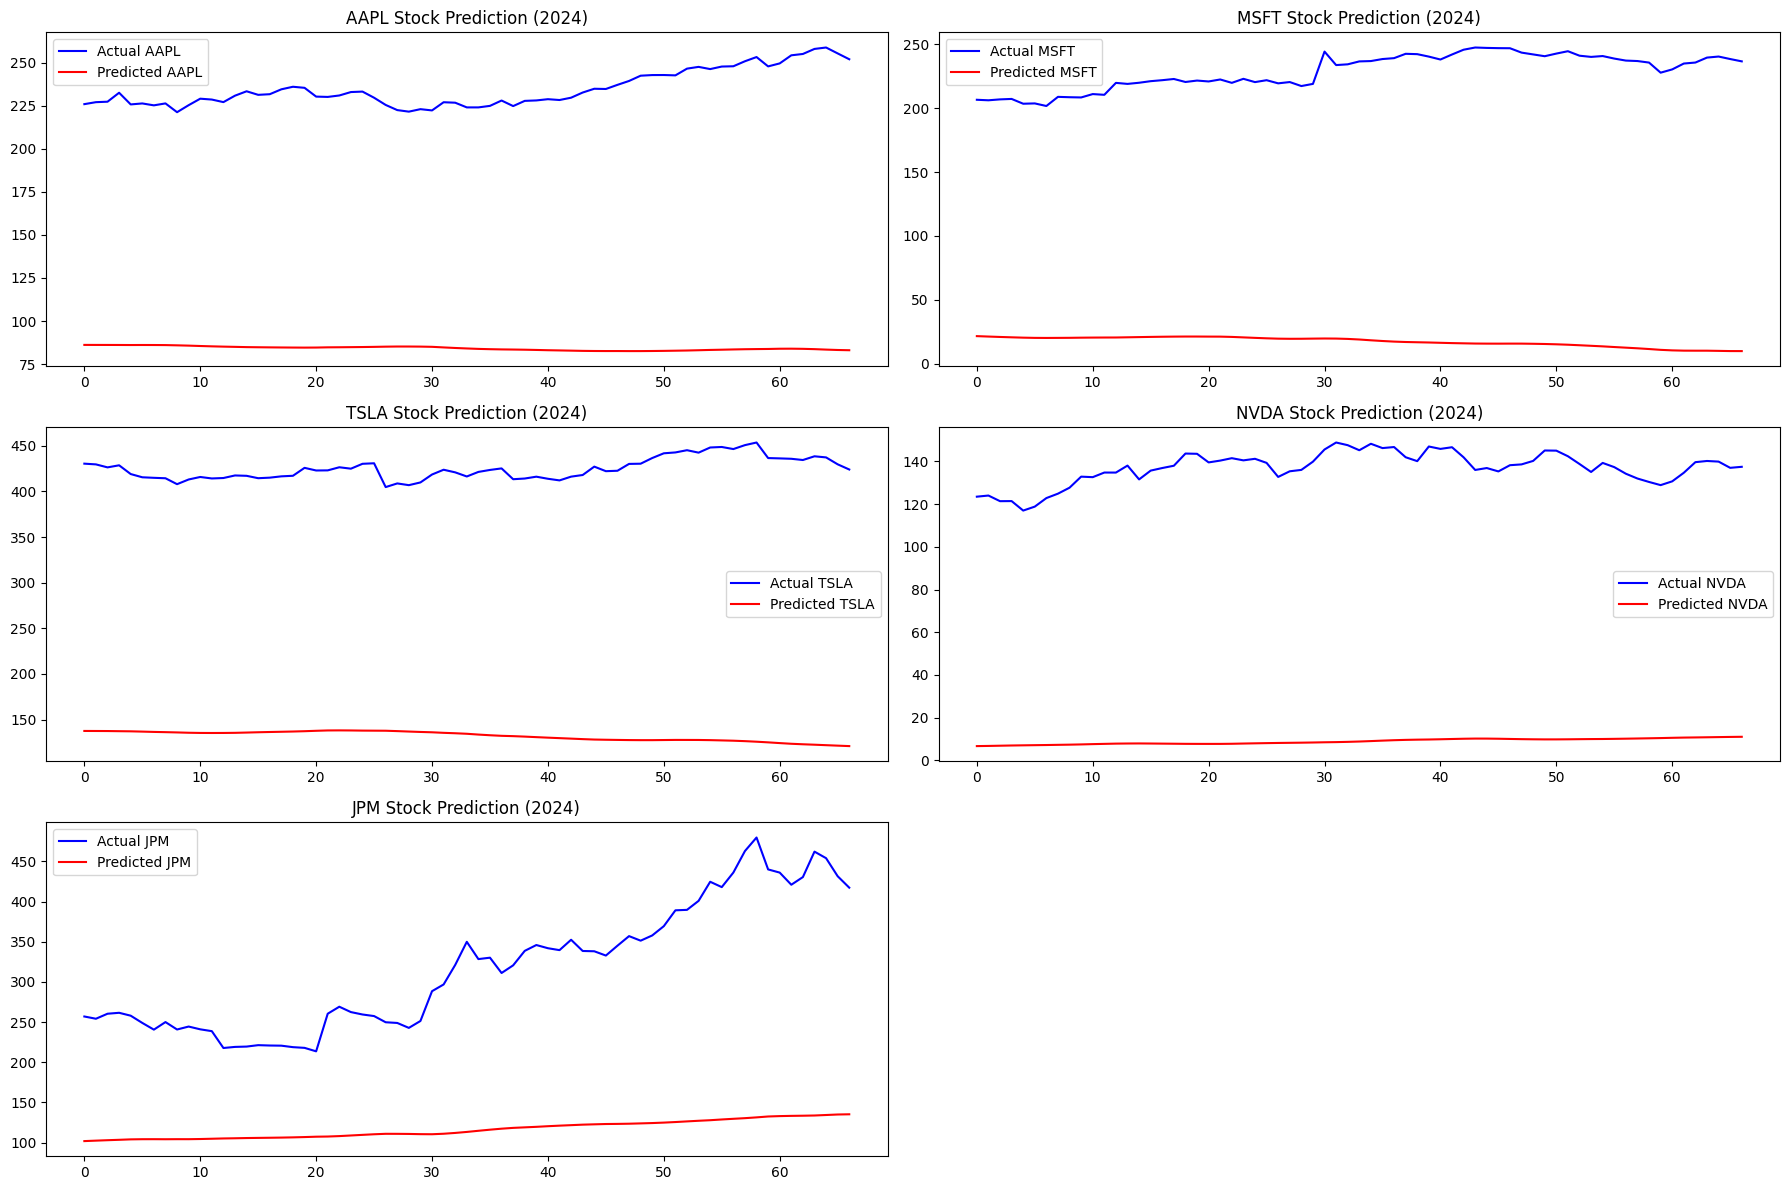

In [ ]:
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)
plt.figure(figsize=(18,12))
for i, stock in enumerate(stocks):
    plt.subplot(3, 2, i+1)
    plt.plot(y_test_rescaled[:,i], label=f'Actual {stock}', color='blue')
    plt.plot(predictions_rescaled[:,i], label=f'Predicted {stock}', color='red')
    plt.title(f'{stock} Stock Prediction (2024)')
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
pred_returns = predictions_rescaled[1:] / predictions_rescaled[:-1] - 1
true_returns = y_test_rescaled[1:] / y_test_rescaled[:-1] - 1
best_stock_indices = np.argmax(pred_returns, axis=1)
portfolio_returns_best = true_returns[np.arange(len(best_stock_indices)), best_stock_indices]
portfolio_returns_equal = true_returns.mean(axis=1)

In [ ]:
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=1_000.0):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.n_steps, self.n_assets = data.shape
        self.initial_balance = initial_balance

        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(self.n_assets * 2 + 1,), dtype=np.float32
        )

        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.portfolio = np.zeros(self.n_assets)
        return self._get_obs()

    def _get_obs(self):
        prices = self.data[self.current_step]
        portfolio_value = np.sum(self.portfolio * prices)
        total_value = self.balance + portfolio_value

        # Normalize portfolio and balance
        norm_portfolio = (self.portfolio * prices) / (total_value + 1e-8)
        norm_balance = self.balance / (total_value + 1e-8)

        obs = np.concatenate((prices, norm_portfolio, [norm_balance]))
        return obs.astype(np.float32)

    def step(self, action):
        action = np.clip(action, 0, 1)
        action = action / (np.sum(action) + 1e-8)

        prices = self.data[self.current_step]
        total_value = self.balance + np.sum(self.portfolio * prices)

        # Update portfolio (invest all based on new weights)
        self.portfolio = (total_value * action) / (prices + 1e-8)
        self.portfolio = np.clip(self.portfolio, 0, 1e6)  # prevent exploding values
        self.balance = 0

        self.current_step += 1
        done = self.current_step >= self.n_steps - 1

        next_prices = self.data[self.current_step]
        new_value = np.sum(self.portfolio * next_prices)

        reward = (new_value - total_value) / (total_value + 1e-8)
        reward = float(np.clip(reward, -1, 1))  # prevent reward explosions

        return self._get_obs(), reward, done, {}

    def render(self, mode='human'):
        prices = self.data[self.current_step]
        value = self.balance + np.sum(self.portfolio * prices)
        print(f"Step: {self.current_step}, Total Value: {value:.2f}")

In [ ]:
# Use the training dataset
train_env = DummyVecEnv([lambda: StockTradingEnv(train_set)])

# Create the DDPG model
model = DDPG(
    "MlpPolicy",
    train_env,
    verbose=1,
    learning_rate=1e-5,         # Lower LR for stability
    buffer_size=50000,
    batch_size=64,
    tau=0.005,                  # Target network update rate
    train_freq=1,
    gradient_steps=1
)

# Train the model
model.learn(total_timesteps=50_000)

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 66       |
|    time_elapsed    | 59       |
|    total_timesteps | 4016     |
| train/             |          |
|    actor_loss      | -0.357   |
|    critic_loss     | 0.0291   |
|    learning_rate   | 1e-05    |
|    n_updates       | 3915     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 68       |
|    time_elapsed    | 117      |
|    total_timesteps | 8032     |
| train/             |          |
|    actor_loss      | -0.415   |
|    critic_loss     | 0.00435  |
|    learning_rate   | 1e-05    |
|    n_updates       | 7931     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 68       |
|    time_elapsed    | 176     

In [ ]:
def evaluate_model(model, data, name=""):
    env = StockTradingEnv(data)
    obs = env.reset()
    total_rewards = 0

    print(f"\n--- Evaluating on {name} set ---")
    for _ in range(len(data) - 1):
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        total_rewards += reward
        if done:
            break
    env.render()
    print(f"Total profit: {total_rewards:.2f}\n")

evaluate_model(model, val_set, "Validation")
evaluate_model(model, test, "Test")


--- Evaluating on Validation set ---
Step: 124, Total Value: 1135.81
Total profit: 0.14


--- Evaluating on Test set ---
Step: 126, Total Value: 1395.18
Total profit: 0.37



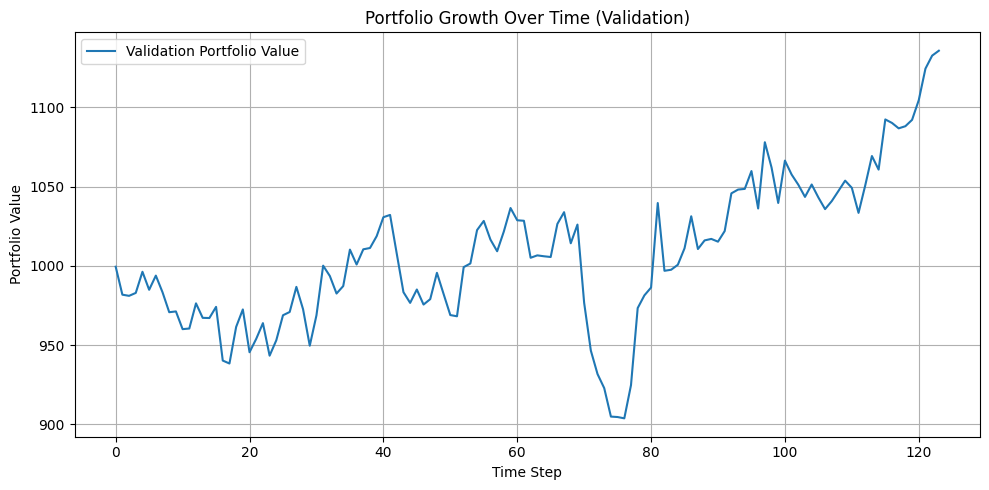

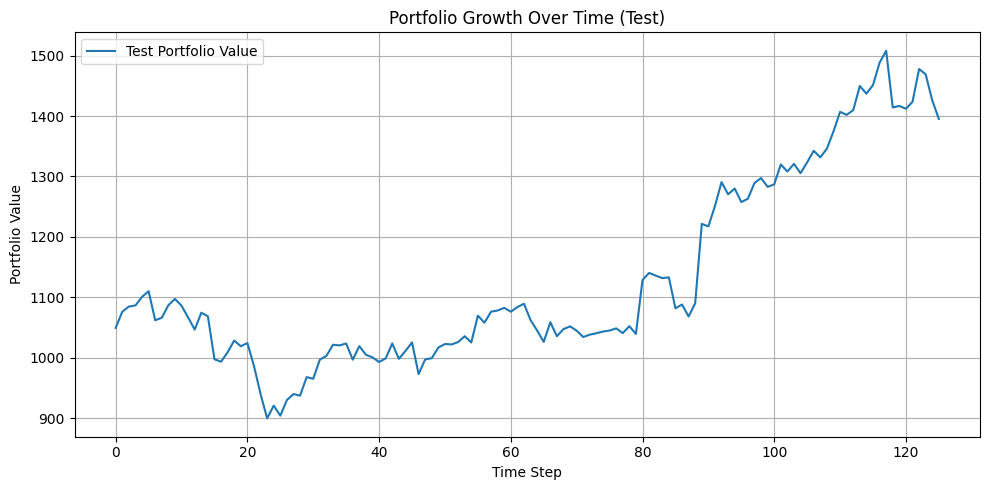

In [ ]:
def evaluate_and_plot(model, data, name=""):
    env = StockTradingEnv(data)
    obs = env.reset()

    portfolio_values = []
    steps = []

    for step in range(len(data) - 1):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _ = env.step(action)
        prices = data[env.current_step]
        portfolio_value = env.balance + np.sum(env.portfolio * prices)

        portfolio_values.append(portfolio_value)
        steps.append(step)

        if done:
            break

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(steps, portfolio_values, label=f'{name} Portfolio Value')
    plt.xlabel('Time Step')
    plt.ylabel('Portfolio Value')
    plt.title(f'Portfolio Growth Over Time ({name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Evaluate and plot on validation and test sets
evaluate_and_plot(model, val_set, name="Validation")
evaluate_and_plot(model, test, name="Test")